# Filter for pairwise retrosynthesizability

## Aim of this notebook

This notebook is filtering the fragments for pairwise retrosynthesizability using the web API from [ASKCOS](https://askcos.mit.edu/).

We build all valid fragment pairs and look if a retrosynthetic route can be found to create this pair from the fragments given. To reduce the number of requests we, first apply all filters from the previous notebooks.

## Table of contents
1. Load fragment library
2. Apply filters
    
    2.1. Apply pre-filters
    
    2.2. Apply filters for unwanted substructures
    
        2.2.1. PAINS filter
        
        2.2.2 Brenk filter
    
    2.3. Apply filters for drug likeness
        
        2.3.1. Rule of Three filter
        
        2.3.2. Quantitative Estimate of Druglikeness filter
        
    2.4. Apply filters for synthesizability
    
        2.4.1. Filter for buyable building blocks
        
        2.4.2. Filter for Synthetic Bayesian Estimation
        
    2.5. Save filtering results for Analysis
    
    2.6. Remove fragments not passing the previous filtering steps
    
3. Apply pairwise retrosynthesizability

    3.1. Get valid fragment pairs
    
    3.2. Calculate pairwise retrosynthesizability
    
4. Analyze accepted/ rejected fragments

    4.1. Count number of accepted/rejected fragments
    
    4.2. Plot number of retrosynthetic routes found per fragment and subpocket
    
    4.3. Inspect fragments with no retrosynthetic routes found and with most retrosynthetic routes found
    
    4.4 Save custom filtered fragment library
    
        4.4.1. Add results from pairwise retrosynthesizability to the filtering results
        
        4.4.2. Save fragment_library_custom_filtered to data

## Imports and preprocessing

In [1]:
import warnings
import pandas as pd
from pathlib import Path
from rdkit.Chem import Draw, PandasTools
from kinfraglib import filters, utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"
PATH_DATA_BRENK = PATH_DATA / "filters/Brenk"
PATH_DATA_ENAMINE = HERE / "../../data/filters/DataWarrior"
PATH_DATA_RETRO = HERE / "../../data/filters/retrosynthesizability"
PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered"

## 1. Load fragment library

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [6]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library).reset_index(drop=True).shape

(7486, 15)

## 2. Apply filters

    2.2. Apply filters for unwanted substructures
    
        2.2.1. PAINS filter
        
        2.2.2 Brenk filter
    
    2.3. Apply filters for drug likeness
        
        2.3.1. Rule of Three filter
        
        2.3.2. Qunatitative Estimate of Druglikeness filter
        
    2.4. Apply filters for synthesizability
    
        2.4.1. Filter for buyable building blocks
        
        2.4.2. Filter for Synthetic Bayesian Estimation
        
    2.5. Save filtering results for Analysis
    
    2.6. remove fragments not passing the previous filtering steps

### 2.1. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library = filters.prefilters.pre_filters(fragment_library)

### 2.2. Apply filters for unwanted substructures
Filter out fragments that could cause unwanted side effects.

For more information, check [/notebooks/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb](https://github.com/sonjaleo/KinFragLib/blob/custom-base/notebooks/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb)

#### 2.2.1. PAINS filter
Remove fragments that can appear as false positive hits in HTS assays.

[ J. Med. Chem. 2010, 53, 7, 2719–2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)

In [9]:
fragment_library, _ = filters.unwanted_substructures.get_pains(fragment_library)

#### 2.2.2 Brenk filter
Remove fragments containing substructures which do not enrich libraries for lead like compounds, defined by Brenk et al. ([ChemMedChem, 2008, 3(3),435--444](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).

In [10]:
fragment_library, brenk_structs = filters.unwanted_substructures.get_brenk(
    fragment_library, PATH_DATA_BRENK
)

Number of unwanted substructures in Brenk et al. collection: 104


### 2.3. Apply filters for drug likeness
For more information, check [/notebooks/custom_kinfraglib/1_2_custom_filters_drug_likeness.ipynb](https://github.com/sonjaleo/KinFragLib/blob/custom-base/notebooks/custom_kinfraglib/1_2_custom_filters_drug_likeness.ipynb)

#### 2.3.1. Rule of Three filter
Filter the fragments according to the Rule of Three ([Drug Discovery Today, 2003, 8(19):876-877](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)).

In [11]:
fragment_library = filters.drug_likeness.get_ro3_frags(fragment_library)

####  2.3.2. Quantitative Estimate of Druglikeness filter
The Quantitative Estimate of Druglikeness reflects the molecular properties ([Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)).

In [12]:
fragment_library = filters.drug_likeness.get_qed(fragment_library, cutoff_val=0.492)

### 2.4. Apply filters for synthesizability

For more information, check [/notebooks/custom_kinfraglib/1_3_custom_filters_synthesizability.ipynb](https://github.com/sonjaleo/KinFragLib/blob/custom-base/notebooks/custom_kinfraglib/1_3_custom_filters_synthesizability.ipynb)

#### 2.4.1. Filter for buyable building blocks
Building blocks can be used to synthesize molecules on demand.

In [13]:
fragment_library = filters.synthesizability.check_building_blocks(
    fragment_library,
    str(str(PATH_DATA_ENAMINE) + "/Enamine_Building_Blocks.sdf"),
)

#### 2.4.2. Filter for Synthetic Bayesian Estimation
The Synthetic Bayesian Estimation is a fragment based estimate, determining whether a molecule is easy or hard to synthesize.

[J Cheminform 12, 35 (2020)](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2) 

In [14]:
fragment_library = filters.synthesizability.calc_syba(fragment_library, cutoff=0)

### 2.5. Save filtering results for Analysis

Check which fragments pass all filters applied.

In [15]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=[
        "bool_pains",
        "bool_brenk",
        "bool_ro3",
        "bool_qed",
        "bool_bb",
        "bool_syba",
    ],
    min_accepted=6)
pd.concat(fragment_library).reset_index(drop=True).shape

(2859, 27)

Count number of fragments pre-filtered and accepted by all filters, or not accepted by at least one filter.

In [16]:
num_fragments_filter = pd.concat([filters.analysis.count_fragments(
    fragment_library,
    "pre_filtered"),
           filters.analysis.count_accepted_rejected(
              fragment_library,
              "bool", "filtered")],
          axis=1)
num_fragments_filter.append(num_fragments_filter.sum().rename('Total'))

,pre_filtered,accepted_filtered,rejected_filtered
subpocket,,,
AP,1001,179,822
FP,862,156,706
SE,606,150,456
GA,306,96,210
B1,42,8,34
B2,42,18,24
Total,2859,607,2252


Save filtering results for analysis

In [17]:
columns = [
    "bool_pains",
    "bool_brenk",
    "bool_ro3",
    "bool_qed",
    "qed",
    "bool_bb",
    "bool_syba",
    "syba",
]
filters.retro.save_filter_results(fragment_library, columns, PATH_DATA_CUSTOM)

### 2.6. Remove fragments not passing the previous filtering steps

In [18]:
for subpocket in fragment_library.keys():
    fragment_library[subpocket].drop(
        fragment_library[subpocket].loc[fragment_library[subpocket]['bool'] == 0].index,
        inplace=True,
    )
    fragment_library[subpocket] = fragment_library[subpocket].reset_index(drop=True)
pd.concat(fragment_library).reset_index(drop=True).shape

(607, 27)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,connections_name,bool_pains,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,bool
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,"[AP=FP, AP=SE]",1,1,1,1,0.565900,1,1,30.950959,1
1,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,...,"[AP=SE, AP=GA]",1,1,1,1,0.511376,1,1,39.622898,1
2,AP,Nc1cc(C2CC2)[nH]n1,,,,ACTR2,STKR,TKL,3soc,GVD,...,[AP=SE],1,1,1,1,0.581756,1,1,18.524861,1
3,AP,Cc1c[nH]c2ncncc12,,,,AKT1,Akt,AGC,3mv5,XFE,...,[AP=FP],1,1,1,1,0.587513,1,1,18.452049,1
4,AP,c1ncc2cc[nH]c2n1,,,,AKT1,Akt,AGC,3ocb,XM1,...,[AP=FP],1,1,1,1,0.560736,1,1,30.638320,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,AP,Nc1ccnn1-c1ccccc1,,,,p38a,MAPK,CMGC,3ocg,OCG,...,[AP=GA],1,1,1,1,0.684047,1,1,33.489899,1
175,AP,O=c1[nH]cncc1Cl,,,,p38a,MAPK,CMGC,3roc,29A,...,"[AP=GA, AP=SE]",1,1,1,1,0.553490,1,1,20.051352,1
176,AP,O=C1CCCCc2ccccc21,,,,p38a,MAPK,CMGC,3uvp,048,...,[AP=GA],1,1,1,1,0.533002,1,1,30.415166,1
177,AP,c1coc(-c2nc[nH]n2)c1,,,,p38a,MAPK,CMGC,5xyx,FTZ,...,[AP=GA],1,1,1,1,0.635714,1,1,35.967668,1

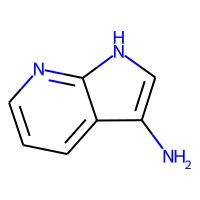
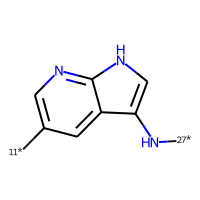
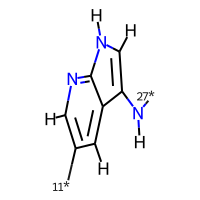
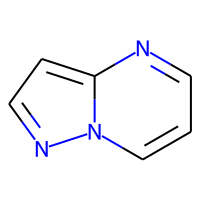
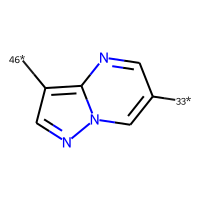
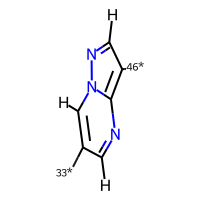
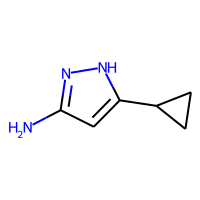
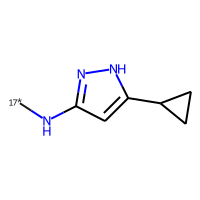
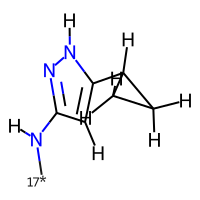
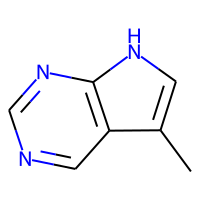
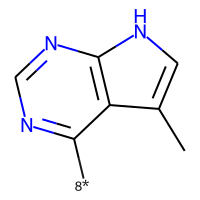
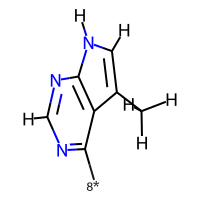
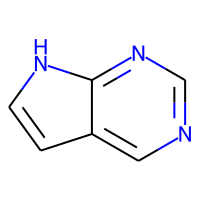
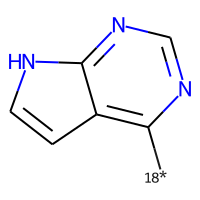
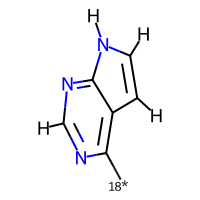
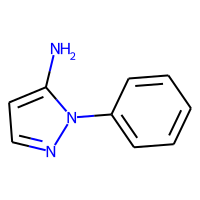
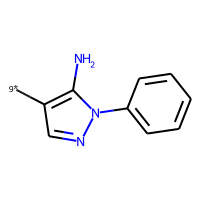
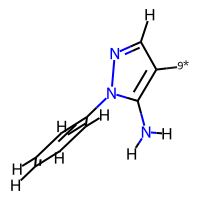
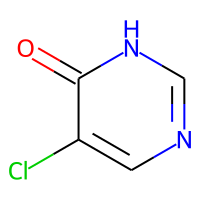
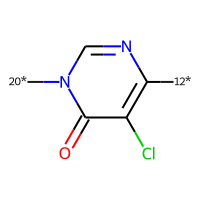
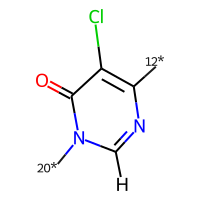
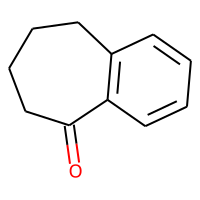
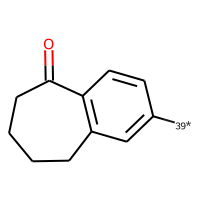
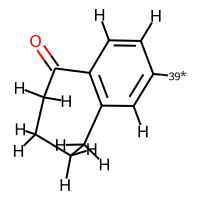
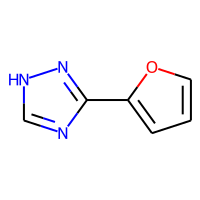
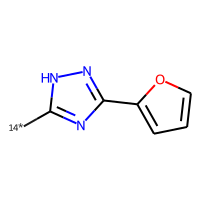
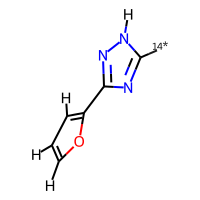
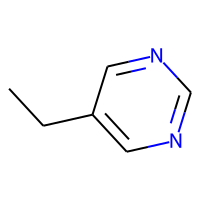
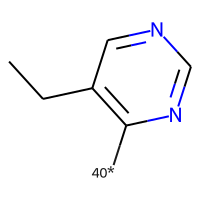
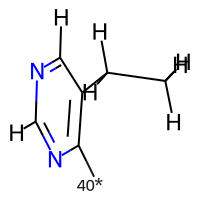

In [19]:
fragment_library["AP"]

## 3. Apply pairwise retrosynthesizability

    3.1. Get valid fragment pairs
    
    3.2. Calculate pairwise retrosynthesizability

### 3.1. Get valid fragment pairs

Note: this function might take a few minutes

In [20]:
valid_fragment_pairs, unique_pairs = filters.retro.get_valid_fragment_pairs(fragment_library)

Number of fragments:  607
Number of unique pairs: 27484


Note: valid_fragment_pairs contains also the duplicated pairs like [AP_0, SE_0] and [SE_0, AP_0]

### 3.2. Calculate pairwise retrosynthesizability
ASKCOS is used to check if for the fragment pairs a retrosynthetic route can be found. We will exclude all fragments without at least one retrosynthetic route found.

[ASKCOS webpage for One-step Retrosynthesis](https://askcos.mit.edu/retro/)

ASKCOS query is started for fragments which were not already computed and children retrieved from ASKCOS get compared with the fragments building the pairs.
Depending on the number of new queries and molecule comparisons this could run a long time (a query of 1000 fragment pairs takes about 1h 30min on an 8 core machine).

Note: If your internet connection is instable, you might need to run this several times. When starting it again it will only compute the pairs which were not yet computed.

In [21]:
%%time
warnings.filterwarnings("ignore") 
fragment_library, mol_df, diff_df = filters.retro.get_pairwise_retrosynthesizability(
    unique_pairs,
    PATH_DATA_RETRO,
    valid_fragment_pairs,
    fragment_library,
)

ASKCOS query started for 0 fragments.
ASKCOS query finished.
Comparing ASKCOS children with fragments..
Checking if all fragment pairs were requested..
All fragment pairs were requested.
Done.
CPU times: user 2min 48s, sys: 5.98 s, total: 2min 54s
Wall time: 4min 9s


Note: if not all fragment pairs were requested, please run this function again.

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,bool,retro_count,bool_retro
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,1,1,1,0.565900,1,1,30.950959,1,0,0
1,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,...,1,1,1,0.511376,1,1,39.622898,1,154,1
2,AP,Nc1cc(C2CC2)[nH]n1,,,,ACTR2,STKR,TKL,3soc,GVD,...,1,1,1,0.581756,1,1,18.524861,1,76,1

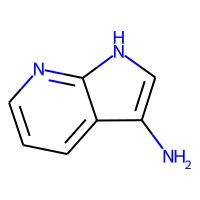
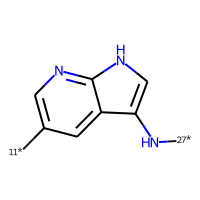
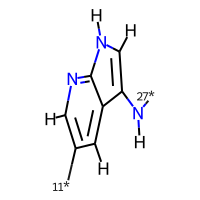
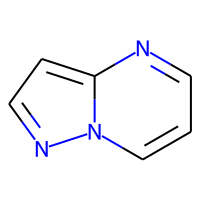
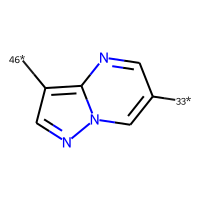
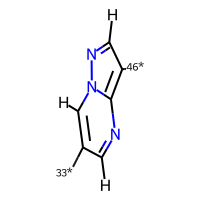
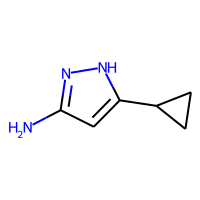
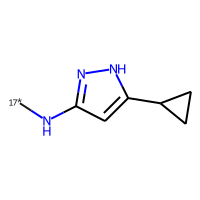
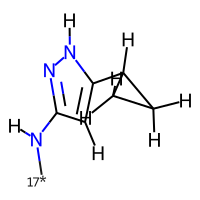

In [22]:
fragment_library["AP"].head(3)

,fragment ids,fragment 1,fragment 2,pair,child 1,child 2,plausibility
0,"[AP_1, SE_1]",,,,,,1
1,"[AP_1, SE_1]",,,,,,1
2,"[AP_1, SE_4]",,,,,,0.999733
3,"[AP_1, SE_5]",,,,,,0.999998
4,"[AP_1, SE_6]",,,,,,0.999997
...,...,...,...,...,...,...,...
58023,"[B2_17, GA_11]",,,,None,None,0
58024,"[B2_17, GA_40]",,,,None,None,0
58025,"[B2_17, GA_45]",,,,None,None,0
58026,"[B2_17, GA_71]",,,,None,None,0

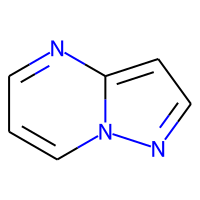
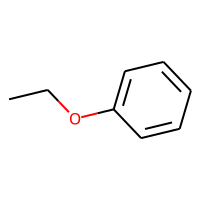
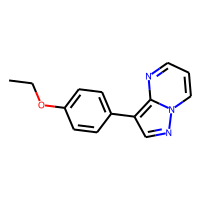
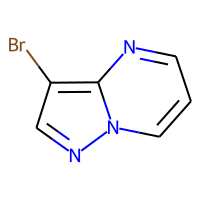
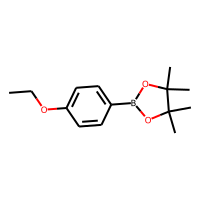
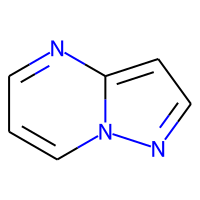
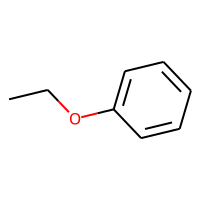
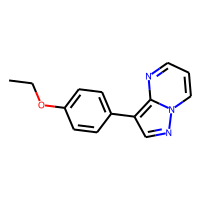
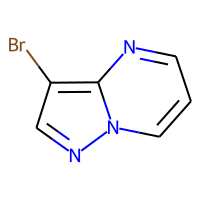
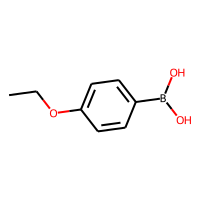
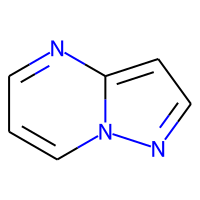
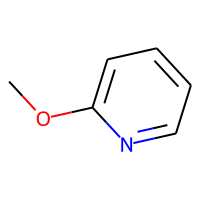
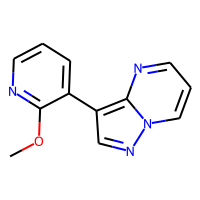
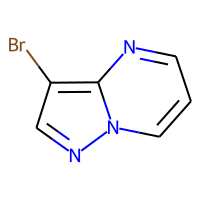
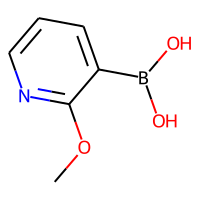
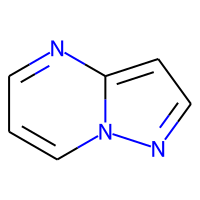
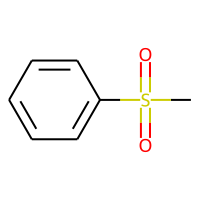
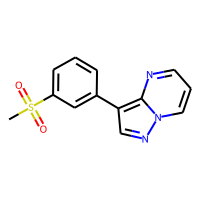
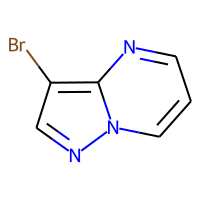
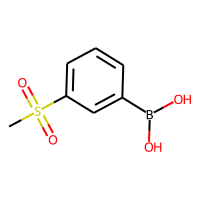
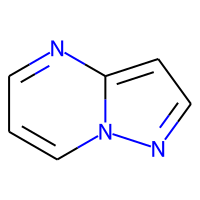
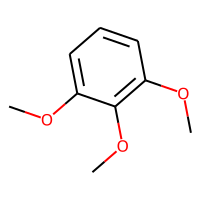
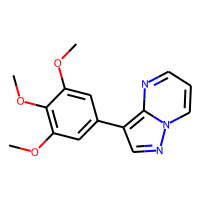
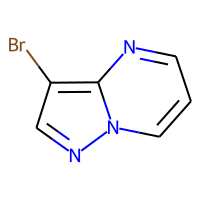
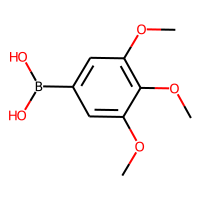
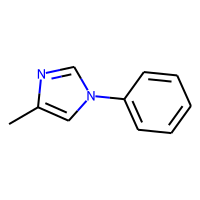
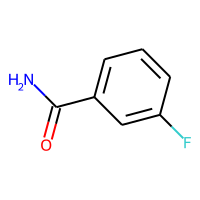
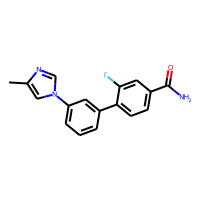
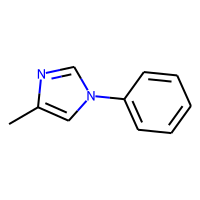
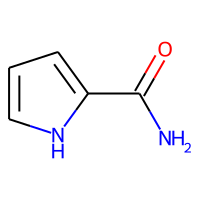
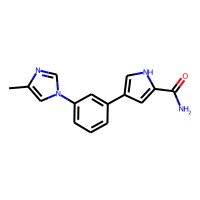
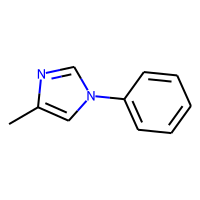
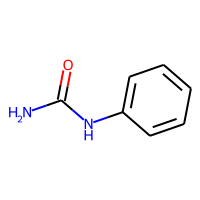
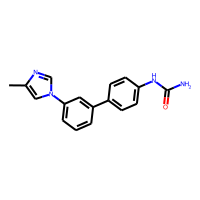
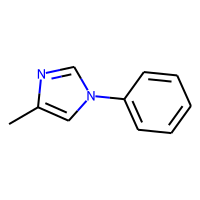
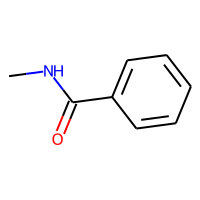
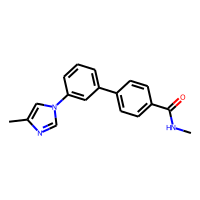
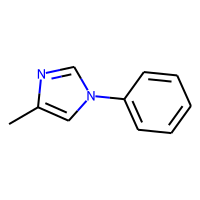
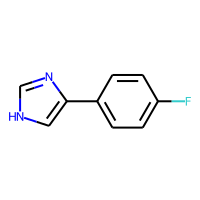
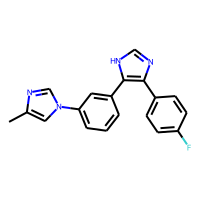

In [23]:
mol_df

,fragment ids,fragment 1,fragment 2,pair,child 1,child 2,plausibility
0,"[AP_1, SE_43]",,,,,,0.999982
1,"[AP_1, GA_48]",,,,,,0.999981
2,"[AP_9, FP_0]",,,,,,0.940733

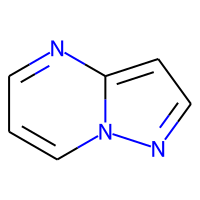
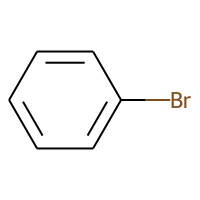
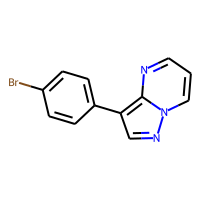
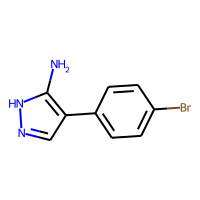
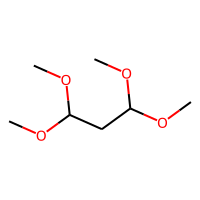
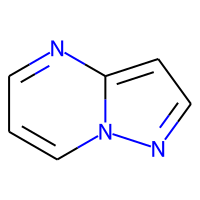
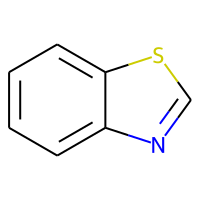
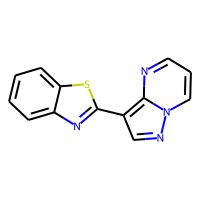
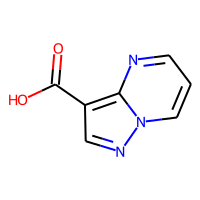
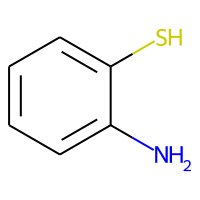
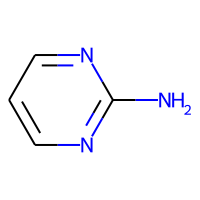
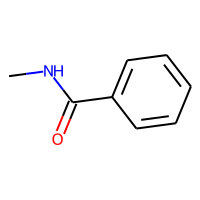
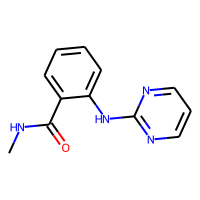
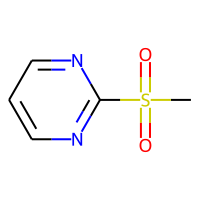
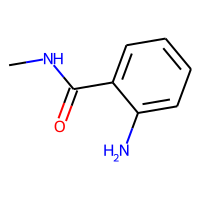

In [24]:
diff_df.head(3)

## 4. Analyze accepted/ rejected fragments

    4.1. Count number of accepted/rejected fragments
    
    4.2. Plot number of retrosynthetic routes found per fragment and subpocket
    
    4.3. Inspect fragments with no retrosynthetic routes found and with most retrosynthetic routes found
    
    4.4 Save custom filtered fragment library
    
        4.4.1. Add results from pairwise retrosynthesizability to the filtering results
        
        4.4.2. Save fragment_library_custom_filtered to data

### 4.1. Count number of accepted/rejected fragments

In [25]:
num_fragments_retro = pd.concat(
    [
        filters.analysis.count_fragments(
            fragment_library, "custom_filtered"
        ),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_retro", "pairwise_retosynthesizability"
        ),
    ],
    axis=1,
)
num_fragments_retro.append(num_fragments_retro.sum().rename("Total"))

,custom_filtered,accepted_pairwise_retosynthesizability,rejected_pairwise_retosynthesizability
subpocket,,,
AP,179,107,72
FP,156,97,59
SE,150,95,55
GA,96,79,17
B1,8,5,3
B2,18,5,13
Total,607,388,219


### 4.2. Plot number of retrosynthetic routes found per fragment and subpocket

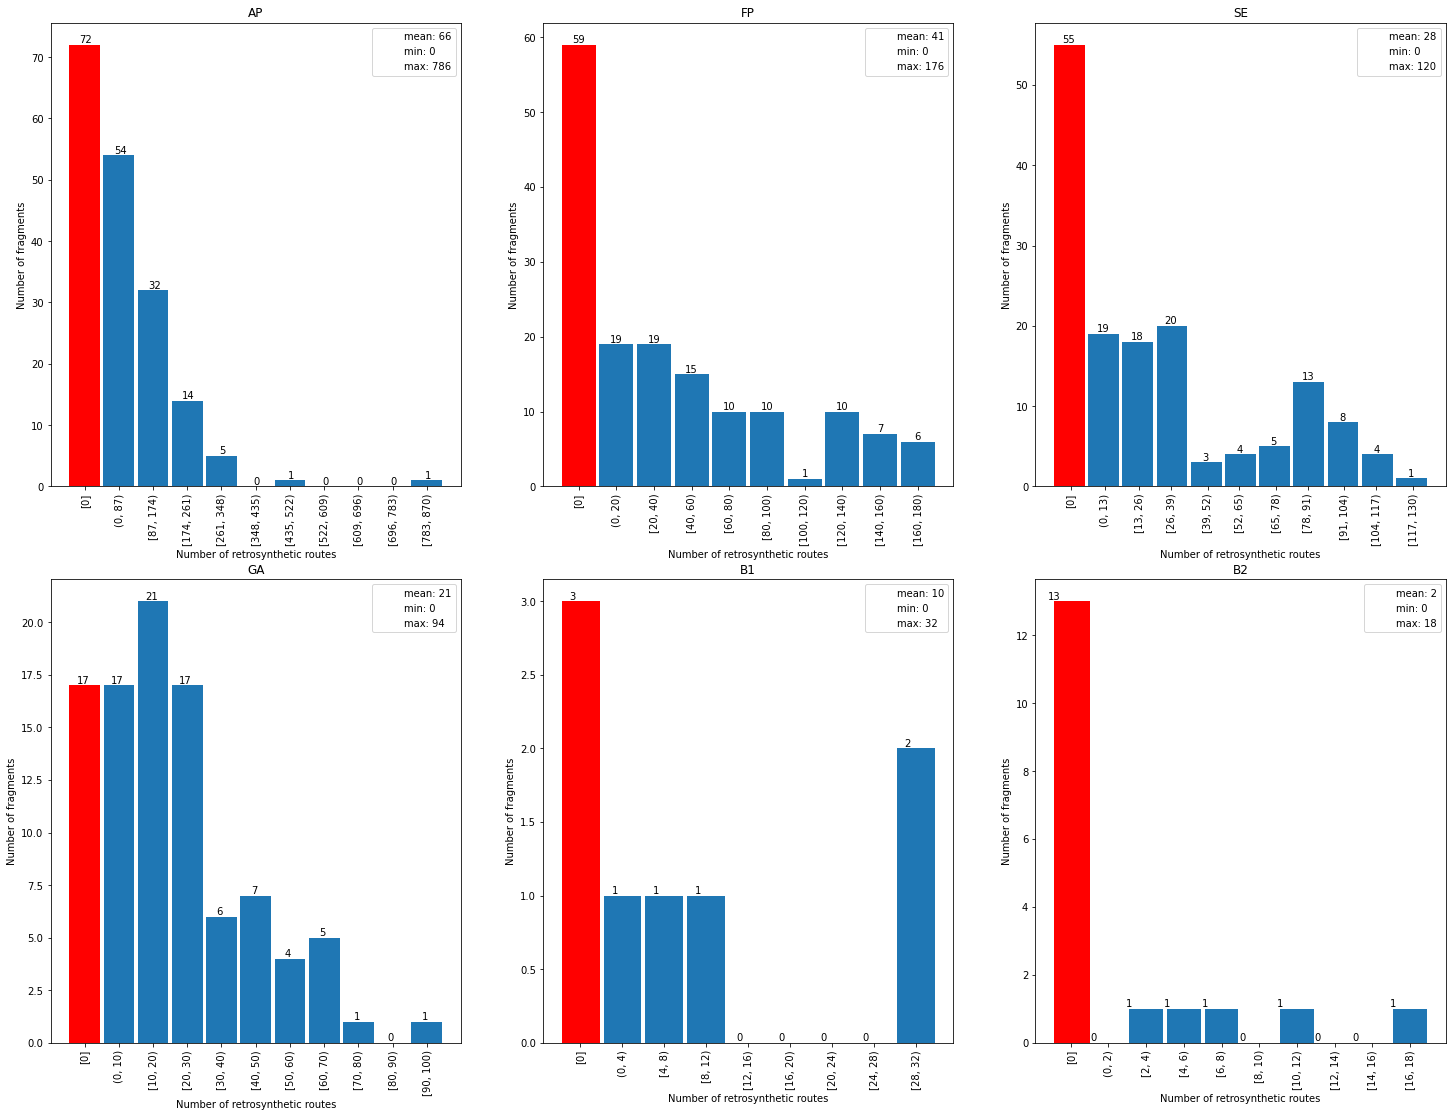

In [26]:
filters.plots.make_retro_hists(fragment_library, "retro_count", cutoff=0)

### 4.3. Inspect fragments with no retrosynthetic routes found and with most retrosynthetic routes found

#### Adenine Pocket (AP)

72 AP fragments with no retrosynthetic route found


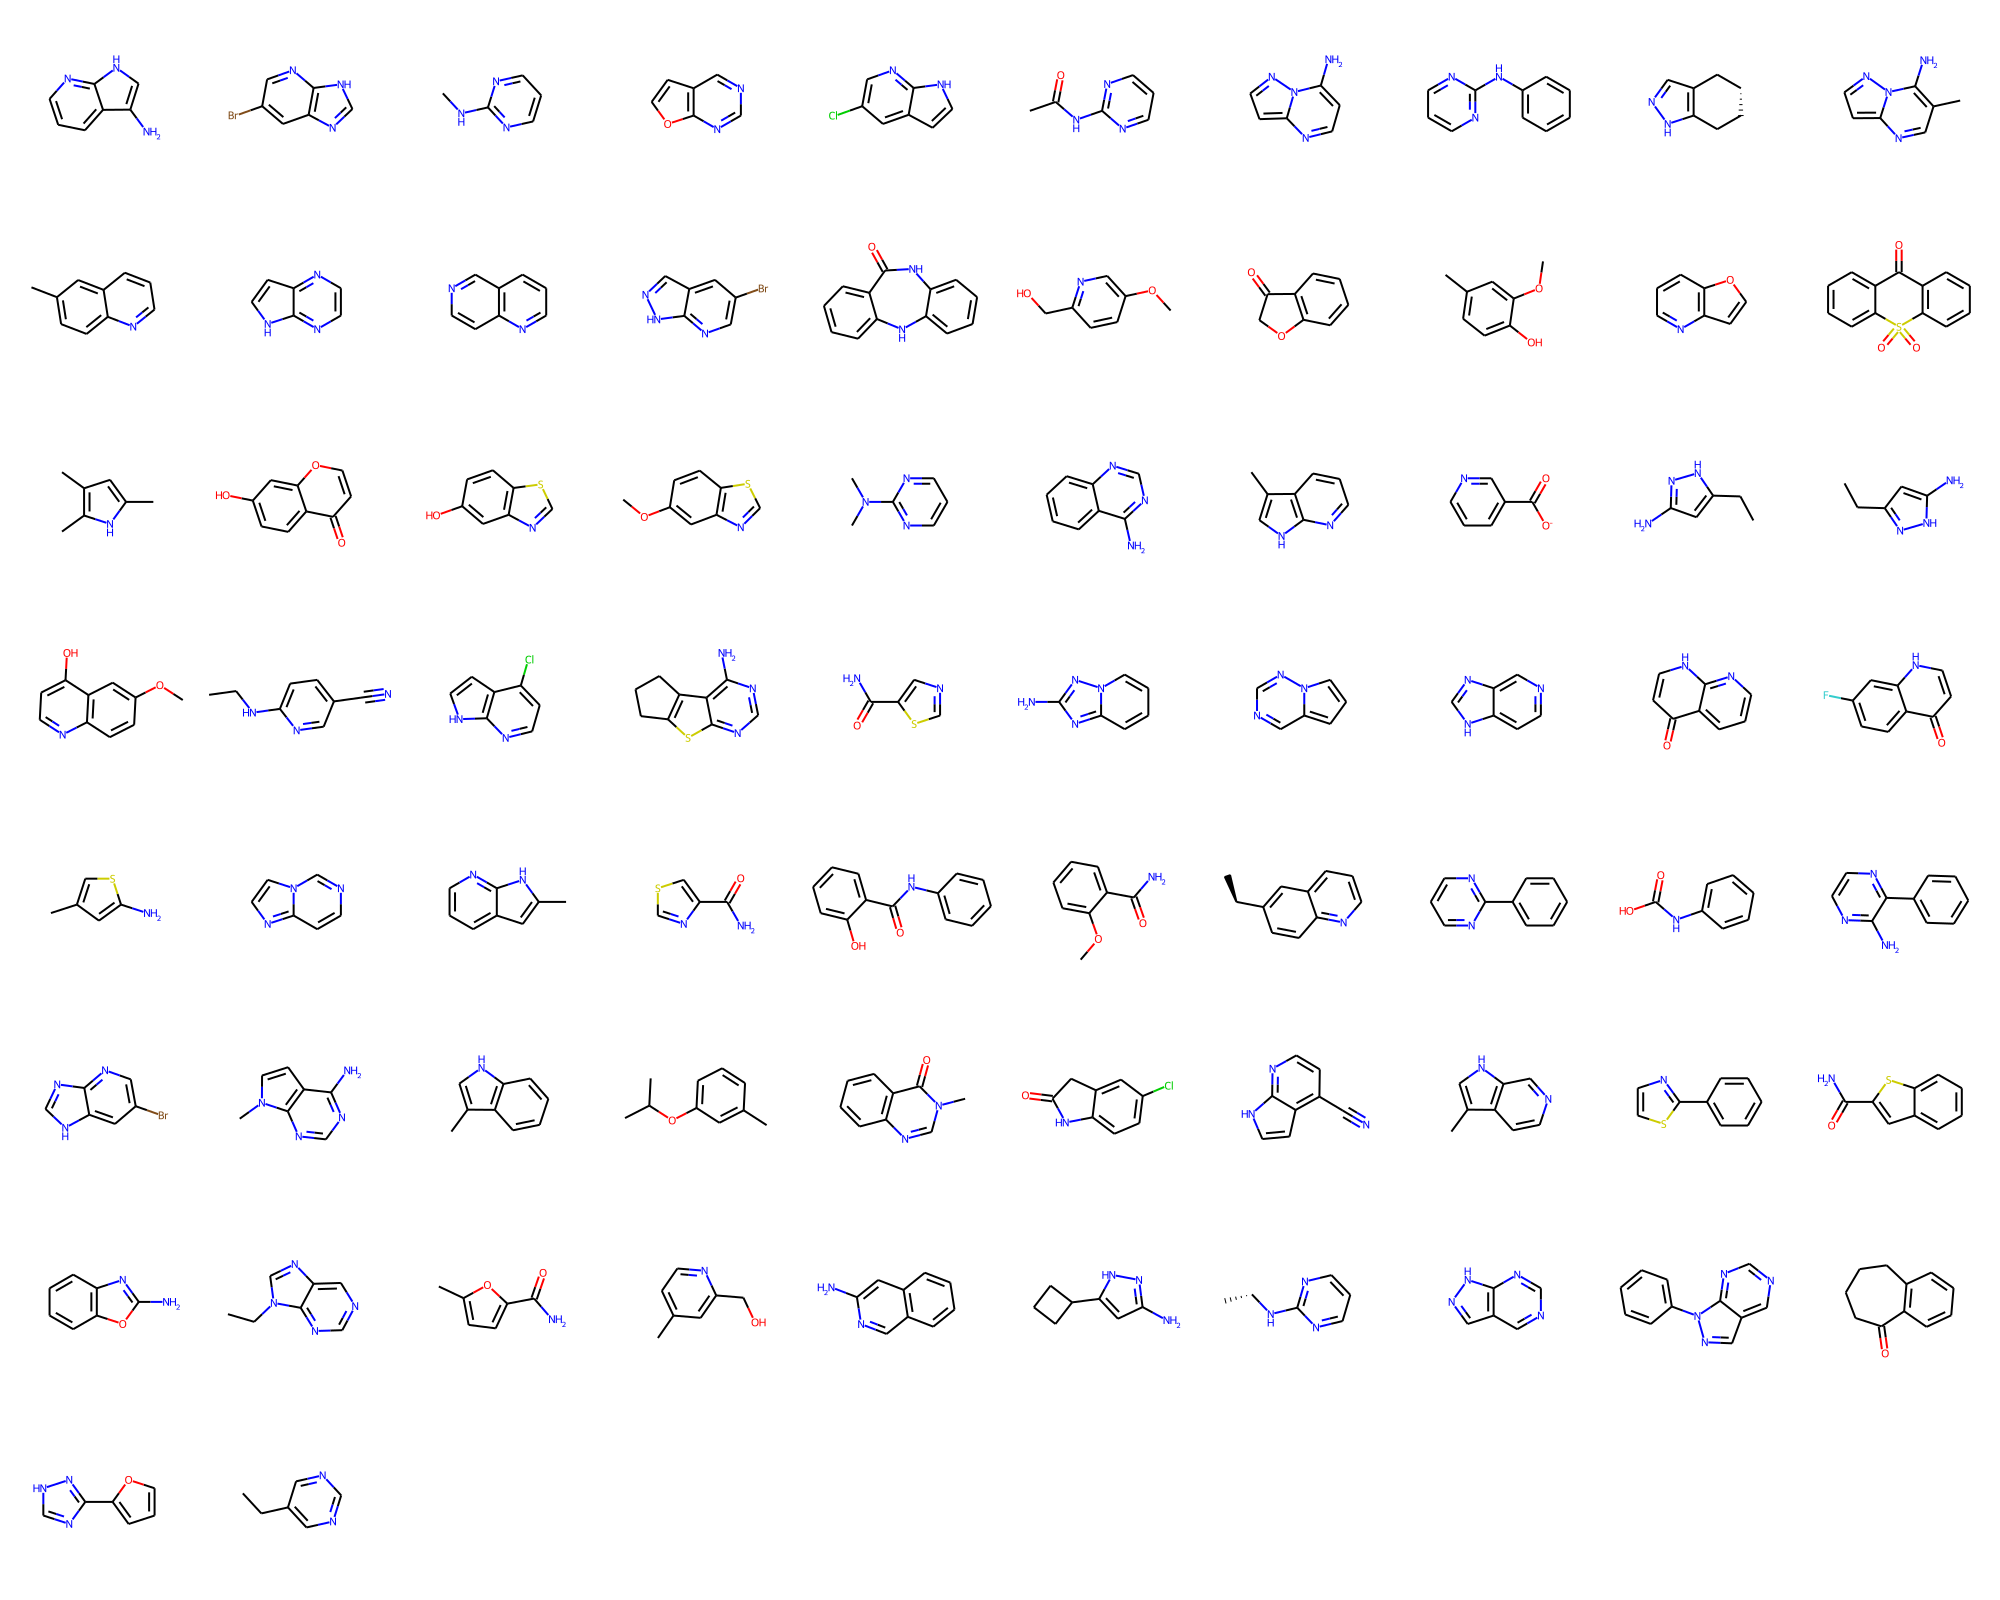

In [27]:
print("%s AP fragments with no retrosynthetic route found" %len(pd.Series(
        fragment_library["AP"][fragment_library["AP"]["retro_count"] == 0].ROMol
        )
    ),
)
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["AP"][fragment_library["AP"]["retro_count"] == 0].ROMol
    ),
    molsPerRow=10,
    maxMols=len(
        pd.Series(fragment_library["AP"][fragment_library["AP"]["retro_count"] == 0].ROMol),
    )
)

10 AP fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


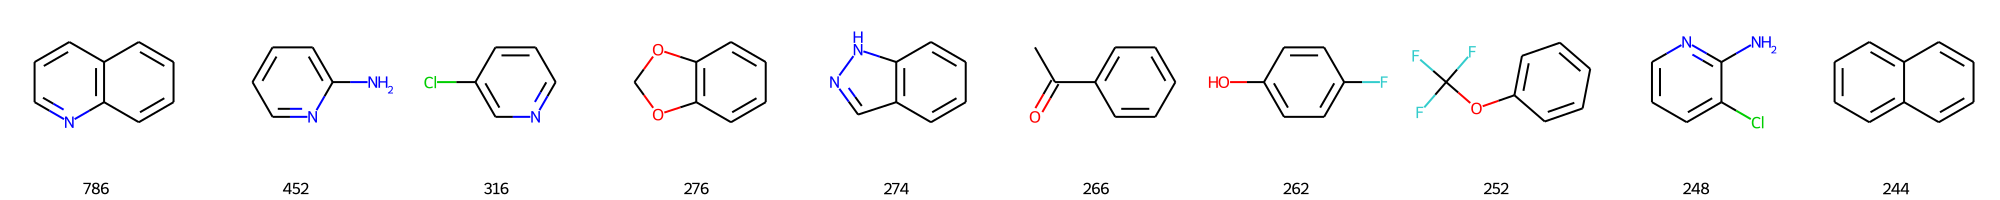

In [28]:
print("10 AP fragments with the most retrosynthetic routes found")
print("legend: number of retrosynthetic routes found")
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["AP"].sort_values("retro_count", ascending=False)[0:10].ROMol
    ),
    molsPerRow=10,
    legends=list(
        fragment_library["AP"].sort_values(
            "retro_count", ascending=False, ignore_index=True
        )[0:10]["retro_count"].astype(str)
    ),
)

#### Front Pocket (FP)

59 FP fragments with no retrosynthetic route found


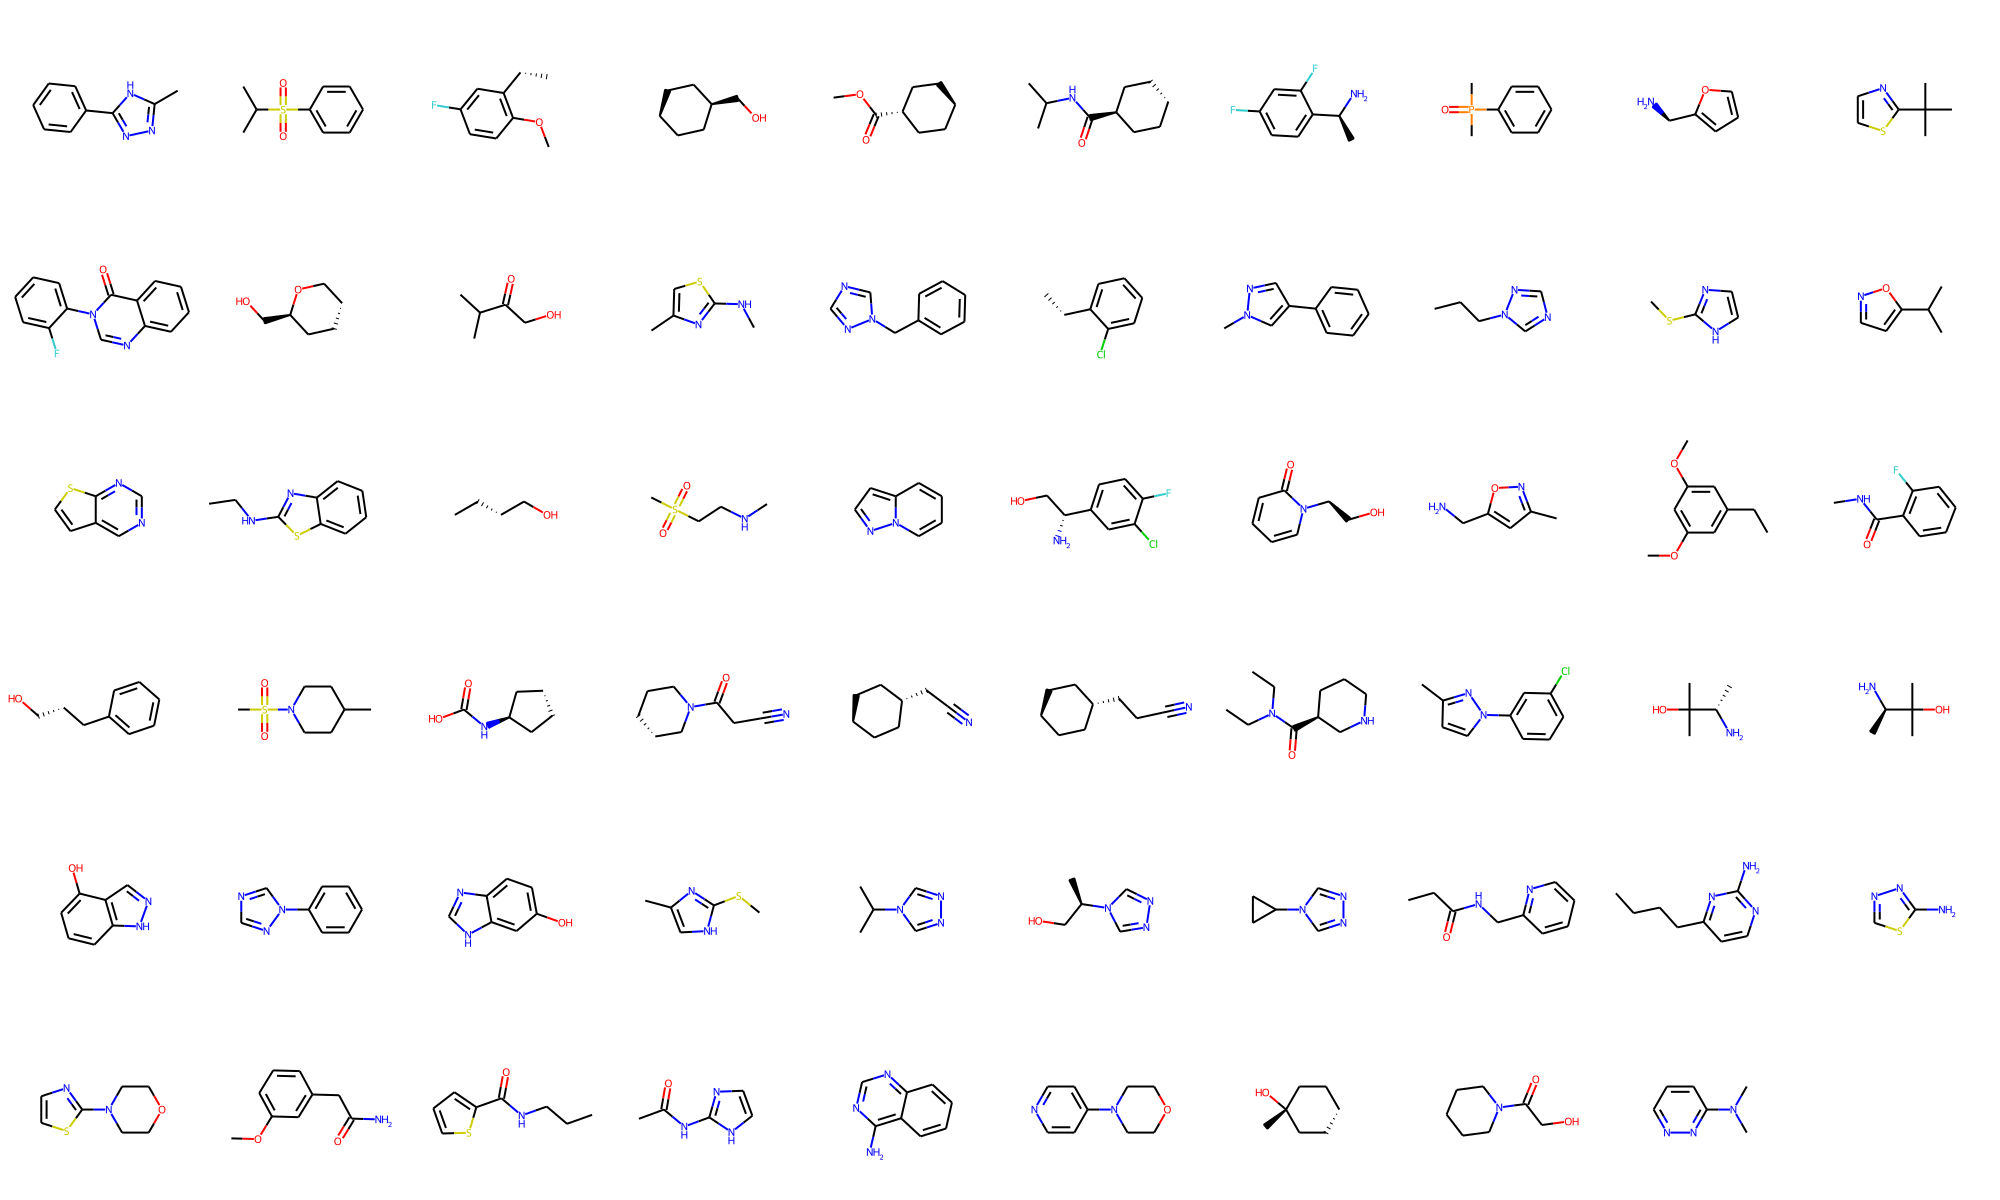

In [29]:
print("%s FP fragments with no retrosynthetic route found" %len(pd.Series(
        fragment_library["FP"][fragment_library["FP"]["retro_count"] == 0].ROMol
        )
    ),
)
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["FP"][fragment_library["FP"]["retro_count"] == 0].ROMol
    ),
    molsPerRow=10,
    maxMols=len(
        pd.Series(fragment_library["FP"][fragment_library["FP"]["retro_count"] == 0].ROMol)
    )
)

10 FP fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


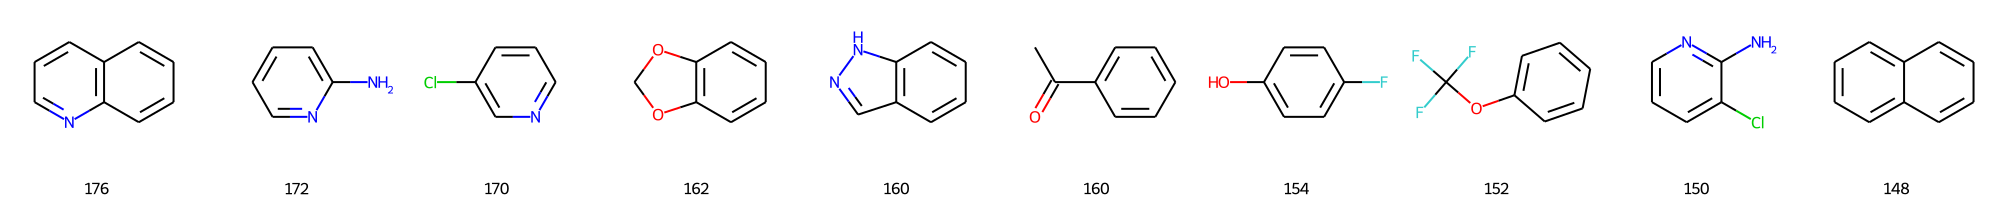

In [30]:
print("10 FP fragments with the most retrosynthetic routes found")
print("legend: number of retrosynthetic routes found")
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["AP"].sort_values("retro_count", ascending=False)[0:10].ROMol
    ),
    molsPerRow=10,
    legends=list(
        fragment_library["FP"].sort_values(
            "retro_count", ascending=False, ignore_index=True
        )[0:10]["retro_count"].astype(str)
    ),
)

#### Solvent Exposed Pocket (SE)

55 SE fragments with no retrosynthetic route found


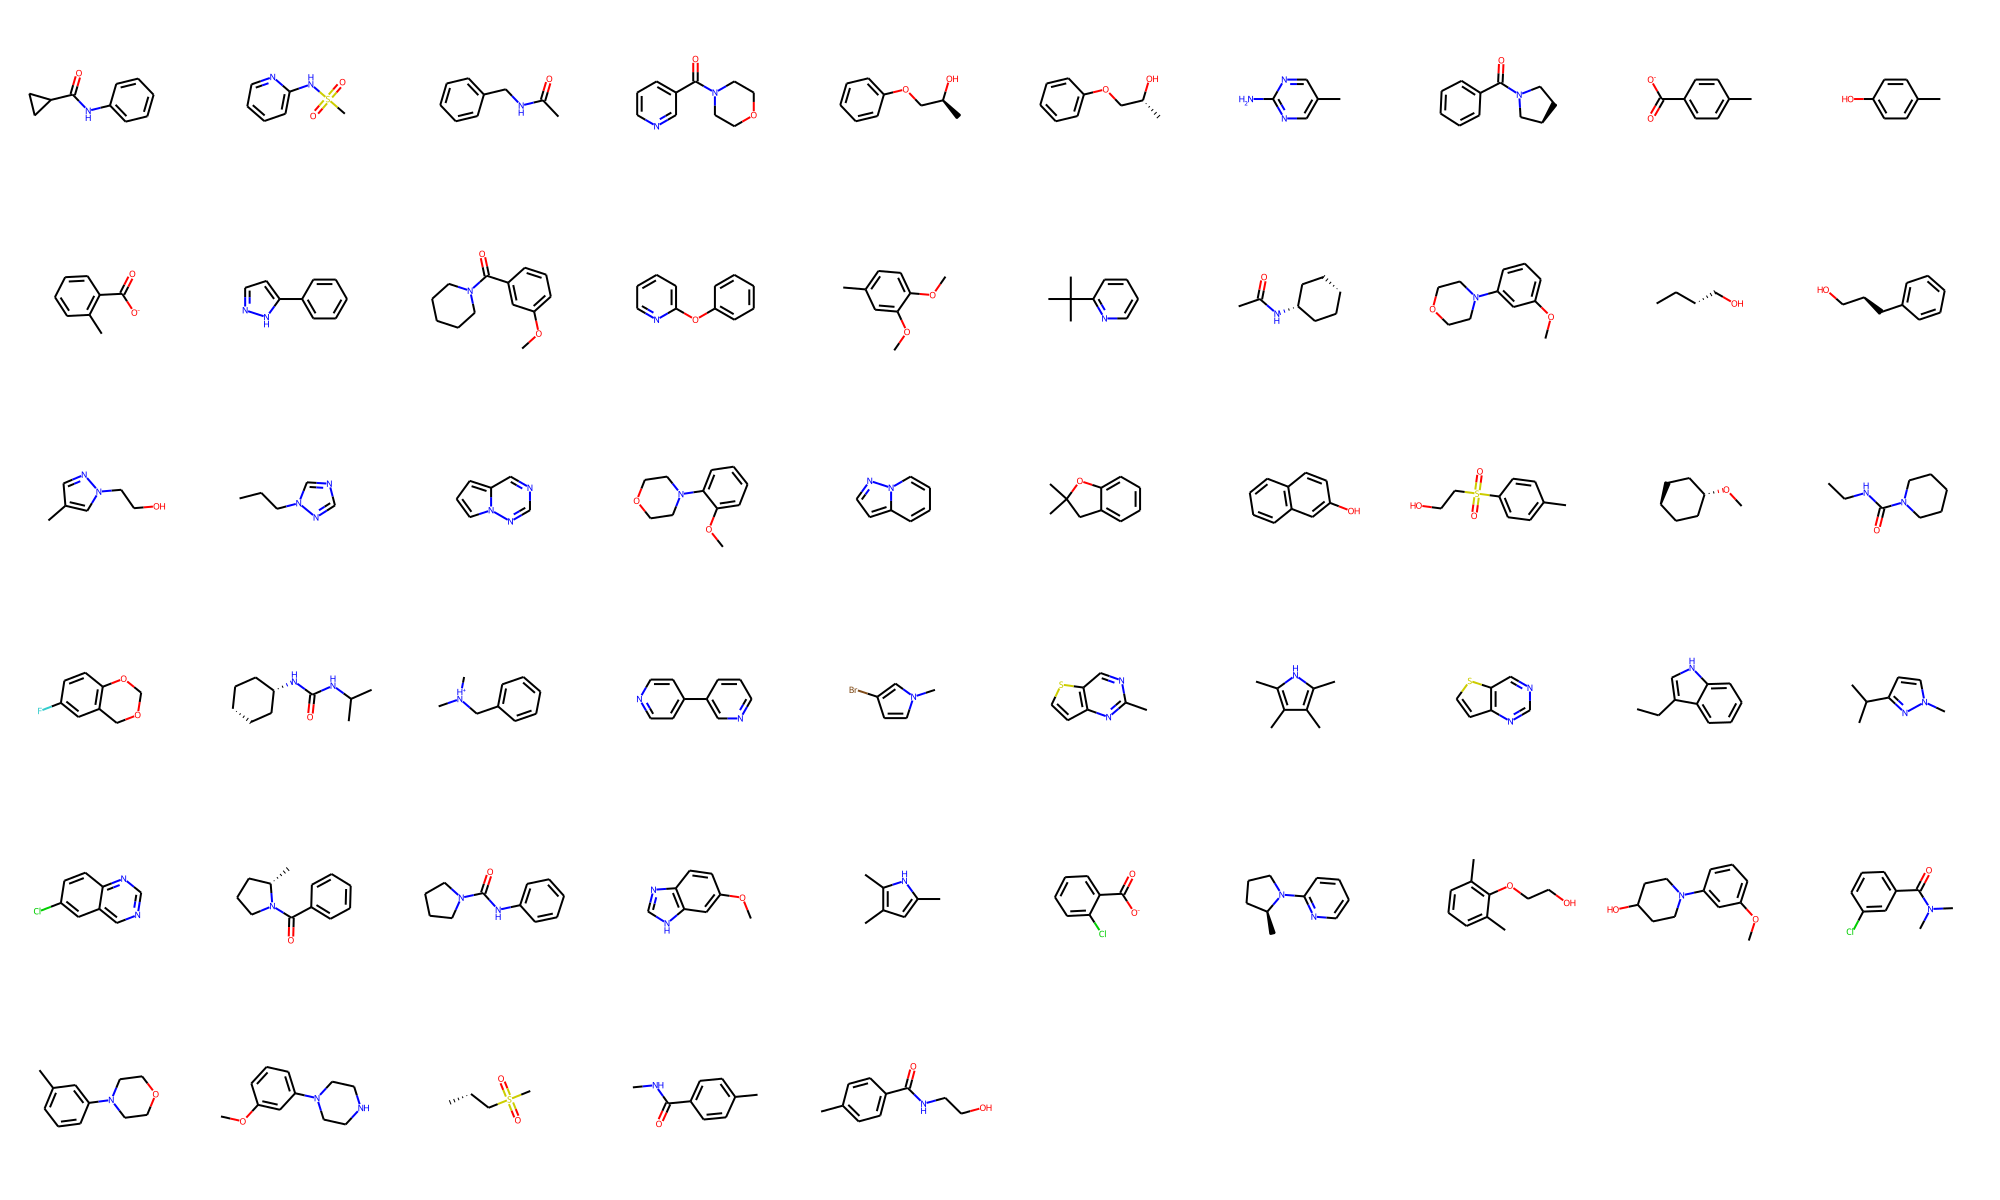

In [31]:
print("%s SE fragments with no retrosynthetic route found" %len(pd.Series(
        fragment_library["SE"][fragment_library["SE"]["retro_count"] == 0].ROMol
        )
    ),
)
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["SE"][fragment_library["SE"]["retro_count"] == 0].ROMol
    ),
    molsPerRow=10,
    maxMols=len(
        pd.Series(fragment_library["SE"][fragment_library["SE"]["retro_count"] == 0].ROMol)
    )
)

10 SE fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


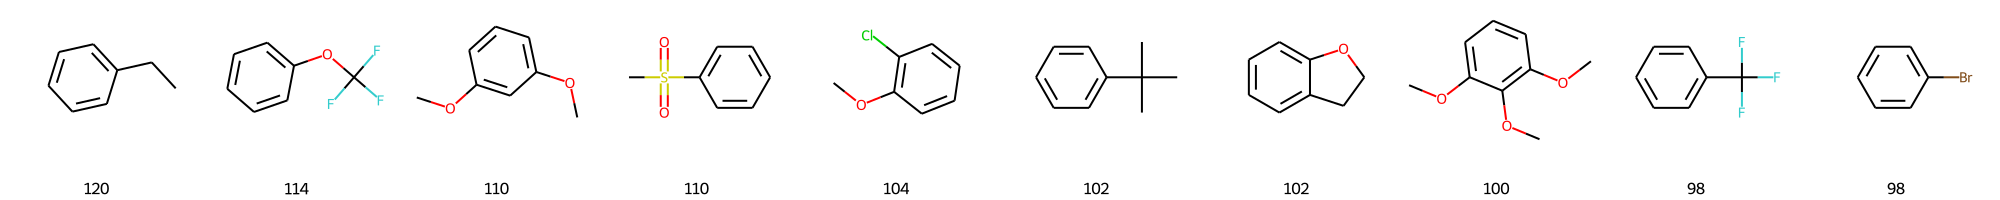

In [32]:
print("10 SE fragments with the most retrosynthetic routes found")
print("legend: number of retrosynthetic routes found")
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["SE"].sort_values("retro_count", ascending=False)[0:10].ROMol
    ),
    molsPerRow=10,
    legends=list(
        fragment_library["SE"].sort_values(
            "retro_count", ascending=False, ignore_index=True
        )[0:10]["retro_count"].astype(str)
    ),
)

#### Gate Area Pocket (GA)

17 GA fragments with no retrosynthetic route found


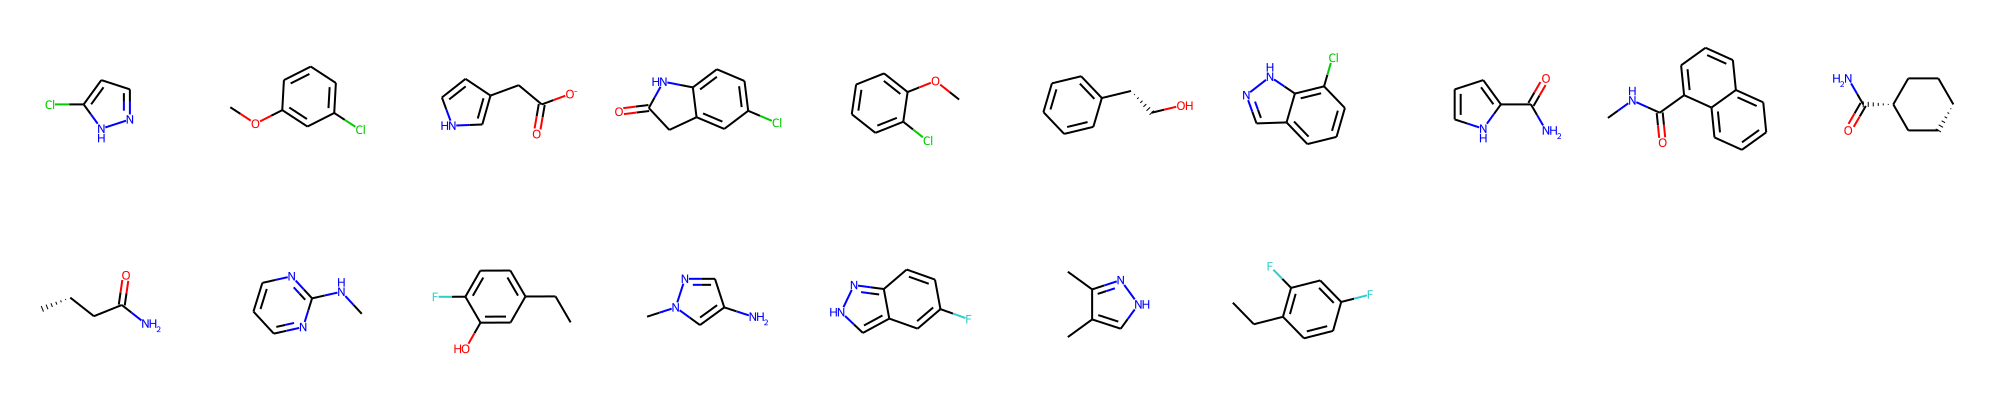

In [33]:
print("%s GA fragments with no retrosynthetic route found" %len(pd.Series(
        fragment_library["GA"][fragment_library["GA"]["retro_count"] == 0].ROMol
        )
    ),
)
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["GA"][fragment_library["GA"]["retro_count"] == 0].ROMol
    ),
    molsPerRow=10,
    maxMols=len(
        pd.Series(
            fragment_library["GA"][fragment_library["GA"]["retro_count"] == 0].ROMol
        )
    )
)

10 GA fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


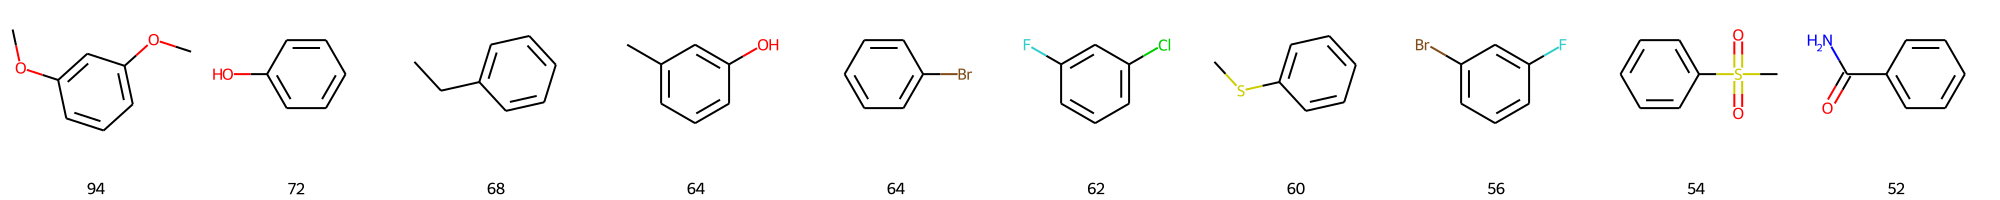

In [34]:
print("10 GA fragments with the most retrosynthetic routes found")
print("legend: number of retrosynthetic routes found")
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["GA"].sort_values("retro_count", ascending=False)[0:10].ROMol
    ),
    molsPerRow=10,
    legends=list(
        fragment_library["GA"].sort_values(
            "retro_count", ascending=False, ignore_index=True
        )[0:10]["retro_count"].astype(str)
    ),
)

#### Back Pocket 1 (B1)

3 B1 fragments with no retrosynthetic route found


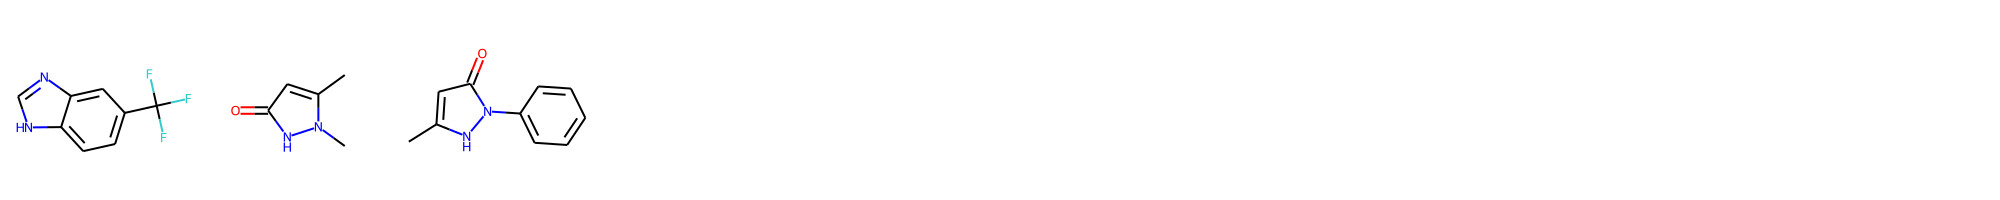

In [35]:
print("%s B1 fragments with no retrosynthetic route found" %len(pd.Series(
        fragment_library["B1"][fragment_library["B1"]["retro_count"] == 0].ROMol
        )
    ),
)
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["B1"][fragment_library["B1"]["retro_count"] == 0].ROMol
    ),
    molsPerRow=10,
    maxMols=len(
        pd.Series(
            fragment_library["B1"][fragment_library["B1"]["retro_count"] == 0].ROMol
        )
    )
)

5 B1 fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


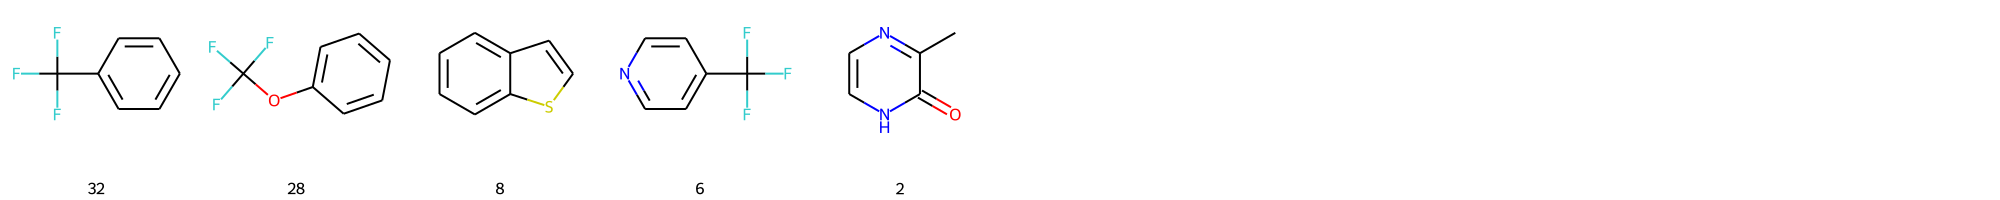

In [36]:
print("%s B1 fragments with the most retrosynthetic routes found" %len(
    pd.Series(
        fragment_library["B1"][fragment_library["B1"]["retro_count"]>0][0:10].ROMol)
    )
)
print("legend: number of retrosynthetic routes found")
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["B1"][fragment_library["B1"]["retro_count"]>0].sort_values("retro_count", ascending=False)[0:10].ROMol
    ),
    molsPerRow=10,
    legends=list(
        fragment_library["B1"].sort_values(
            "retro_count", ascending=False, ignore_index=True
        )[0:10]["retro_count"].astype(str)
    ),
)

#### Back Pocket 2 (B2)

13 B2 fragments with no retrosynthetic route found


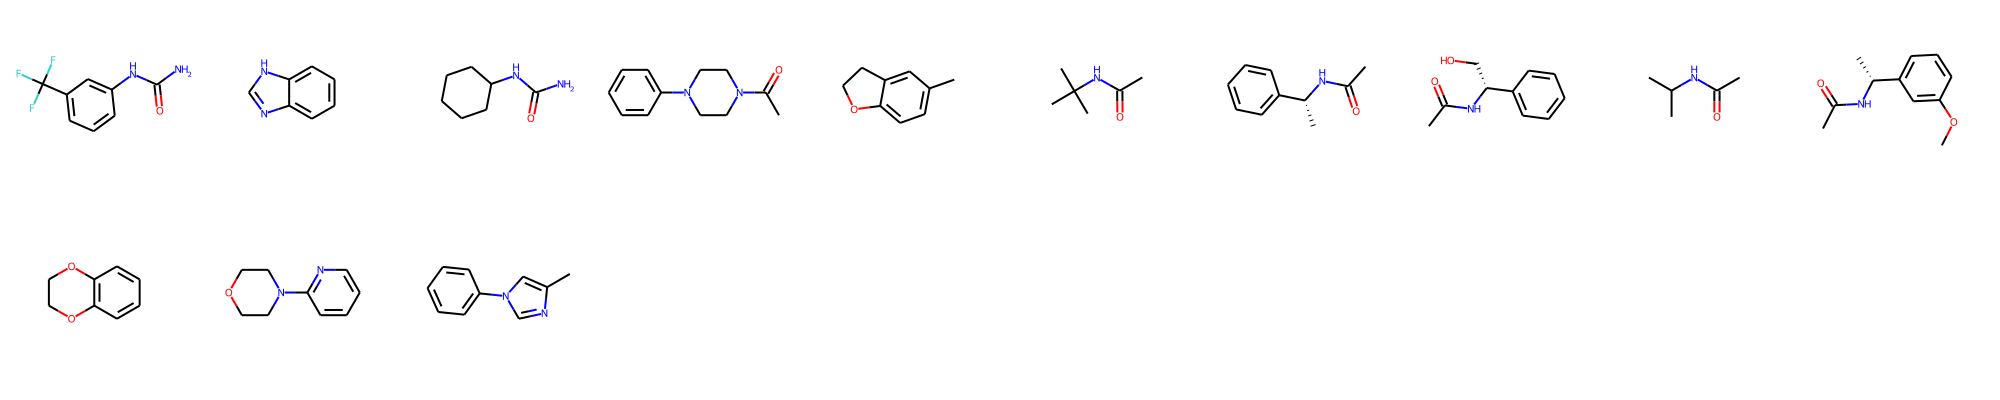

In [37]:
print("%s B2 fragments with no retrosynthetic route found" %len(pd.Series(
        fragment_library["B2"][fragment_library["B2"]["retro_count"] == 0].ROMol
        )
    ),
)
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["B2"][fragment_library["B2"]["retro_count"] == 0].ROMol
    ),
    molsPerRow=10,
    maxMols=len(
        pd.Series(
            fragment_library["B2"][fragment_library["B2"]["retro_count"] == 0].ROMol
        )
    )
)

3 B2 fragments with the most retrosynthetic routes found
legend: number of retrosynthetic routes found


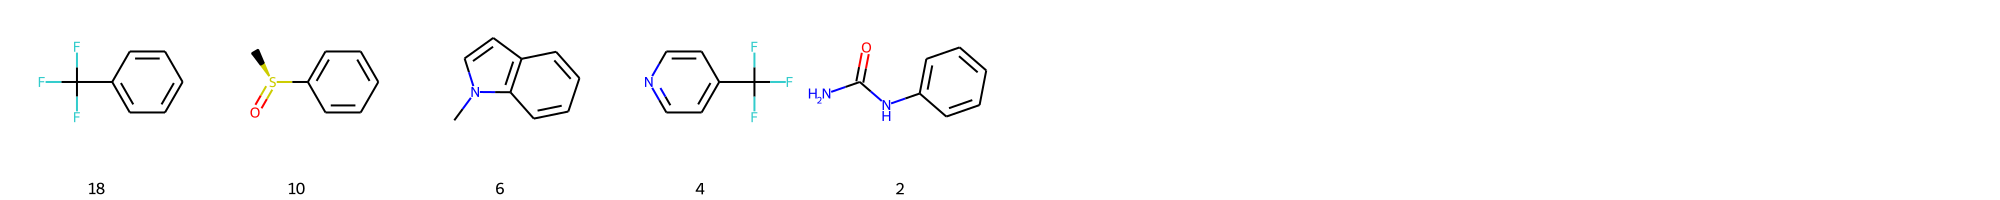

In [38]:
print("%s B2 fragments with the most retrosynthetic routes found" %len(
    pd.Series(
        fragment_library["B1"][fragment_library["B2"]["retro_count"]>0][0:10].ROMol)
    )
)
print("legend: number of retrosynthetic routes found")
Draw.MolsToGridImage(
    pd.Series(
        fragment_library["B2"][fragment_library["B2"]["retro_count"]>0].sort_values("retro_count", ascending=False)[0:10].ROMol
    ),
    molsPerRow=10,
    legends=list(
        fragment_library["B2"].sort_values(
            "retro_count", ascending=False, ignore_index=True
        )[0:10]["retro_count"].astype(str)
    ),
)

### 4.4 Save custom filtered fragment library

#### 4.4.1. Add results from pairwise retrosynthesizability to the filtering results

Load previous filtering results and values from .csv file and add retro results.

In [39]:
saved_filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv")

In [40]:
saved_filter_results.set_index(["subpocket", "smiles"])

bool_pains  bool_brenk  bool_ro3  \
subpocket smiles                                                               
AP        Nc1c[nH]c2ncccc12                          1           1         1   
          N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1           1           0         1   
          Cc1cc(N)[nH]n1                             1           1         1   
          Nc1ncc(C=O)s1                              1           0         1   
          COCC(=O)n1cc2[nH]nc(NC=O)c2c1              1           0         0   
...                                                ...         ...       ...   
B2        Nc1ccon1                                   1           1         1   
          c1cnoc1                                    1           1         1   
          c1ccoc1                                    1           1         1   
          c1ccc(N2CCOCC2)nc1                         1           1         1   
          Cc1cn(-c2ccccc2)cn1                        1           1         1   

                                            bool_qed       qed  bool_bb  \
subpocket smiles                                                          
AP        Nc1c[nH]c2ncccc12                        1  0.565900        1   
          N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1         1  0.747185        0   
          Cc1cc(N)[nH]n1                           0  0.488854        1   
          Nc1ncc(C=O)s1                            1  0.561340        1   
          COCC(=O)n1cc2[nH]nc(NC=O)c2c1            1  0.723961        0   
...                                              ...       ...      ...   
B2        Nc1ccon1                                 0  0.490056        1   
          c1cnoc1                                  0  0.447261        1   
          c1ccoc1                                  0  0.446031        1   
          c1ccc(N2CCOCC2)nc1                       1  0.616781        1   
          Cc1cn(-c2ccccc2)cn1                      1  0.621614        1   

                                            bool_syba       syba  
subpocket smiles                                                  
AP        Nc1c[nH]c2ncccc12                         1  30.950959  
          N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1          1  17.682659  
          Cc1cc(N)[nH]n1                            1  15.727015  
          Nc1ncc(C=O)s1                             1  12.789242  
          COCC(=O)n1cc2[nH]nc(NC=O)c2c1             1  14.653939  
...                                               ...        ...  
B2        Nc1ccon1                                  1  15.503600  
          c1cnoc1                                   1  11.831072  
          c1ccoc1                                   1   5.852398  
          c1ccc(N2CCOCC2)nc1                        1  48.630055  
          Cc1cn(-c2ccccc2)cn1                       1  32.821614  

[2859 rows x 8 columns]

In [41]:
fragment_library_concat = pd.concat(fragment_library)
retro_results_df = pd.DataFrame()
retro_results_df["subpocket"] = fragment_library_concat["subpocket"]
retro_results_df["smiles"] = fragment_library_concat["smiles"]
retro_results_df["retro_count"] = fragment_library_concat["retro_count"]
retro_results_df["bool_retro"] = fragment_library_concat["bool_retro"]
retro_results_df.set_index(["subpocket", "smiles"])

retro_count  bool_retro
subpocket smiles                                      
AP        Nc1c[nH]c2ncccc12              0           0
          c1cnc2ccnn2c1                154           1
          Nc1cc(C2CC2)[nH]n1            76           1
          Cc1c[nH]c2ncncc12             66           1
          c1ncc2cc[nH]c2n1              68           1
...                                    ...         ...
B2        Cn1ccc2ccccc21                 6           1
          c1ccc2c(c1)OCCO2               0           0
          C[S@](=O)c1ccccc1             10           1
          c1ccc(N2CCOCC2)nc1             0           0
          Cc1cn(-c2ccccc2)cn1            0           0

[607 rows x 2 columns]

In [42]:
all_results_df = saved_filter_results.merge(retro_results_df, left_on=['subpocket', 'smiles'], right_on=['subpocket', 'smiles'], how="outer")
all_results_df.to_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv", index=False)

#### 4.4.2. Save fragment_library_custom_filtered to data

Save custom filtered fragment library as .sdf files.

In [43]:
for subpocket in fragment_library.keys():
    fragment_library[subpocket].drop(
        fragment_library[subpocket].loc[fragment_library[subpocket]["bool_retro"] == 0].index,
        inplace=True,
    )
    fragment_library[subpocket] = fragment_library[subpocket].reset_index(drop=True)

subpocket              smiles  \
AP 0        AP       c1cnc2ccnn2c1   
   1        AP  Nc1cc(C2CC2)[nH]n1   
   2        AP   Cc1c[nH]c2ncncc12   
   3        AP    c1ncc2cc[nH]c2n1   
   4        AP      c1ccc2ncncc2c1   

                                                  ROMol  \
AP 0  <img data-content="rdkit/molecule" src="data:i...   
   1  <img data-content="rdkit/molecule" src="data:i...   
   2  <img data-content="rdkit/molecule" src="data:i...   
   3  <img data-content="rdkit/molecule" src="data:i...   
   4  <img data-content="rdkit/molecule" src="data:i...   

                                            ROMol_dummy  \
AP 0  <img data-content="rdkit/molecule" src="data:i...   
   1  <img data-content="rdkit/molecule" src="data:i...   
   2  <img data-content="rdkit/molecule" src="data:i...   
   3  <img data-content="rdkit/molecule" src="data:i...   
   4  <img data-content="rdkit/molecule" src="data:i...   

                                         ROMol_original kinase family group  \
AP 0  <img data-content="rdkit/molecule" src="data:i...  ACTR2   STKR   TKL   
   1  <img data-content="rdkit/molecule" src="data:i...  ACTR2   STKR   TKL   
   2  <img data-content="rdkit/molecule" src="data:i...   AKT1    Akt   AGC   
   3  <img data-content="rdkit/molecule" src="data:i...   AKT1    Akt   AGC   
   4  <img data-content="rdkit/molecule" src="data:i...   AKT1    Akt   AGC   

     complex_pdb ligand_pdb  ... bool_brenk bool_ro3 bool_qed       qed  \
AP 0        3q4t        TAK  ...          1        1        1  0.511376   
   1        3soc        GVD  ...          1        1        1  0.581756   
   2        3mv5        XFE  ...          1        1        1  0.587513   
   3        3ocb        XM1  ...          1        1        1  0.560736   
   4        3qkm        SM9  ...          1        1        1  0.541282   

     bool_bb  bool_syba       syba bool  retro_count  bool_retro  
AP 0       1          1  39.622898    1          154           1  
   1       1          1  18.524861    1           76           1  
   2       1          1  18.452049    1           66           1  
   3       1          1  30.638320    1           68           1  
   4       1          1  36.822281    1           78           1  

[5 rows x 29 columns]
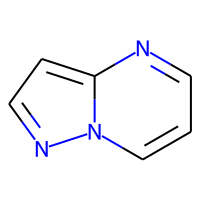
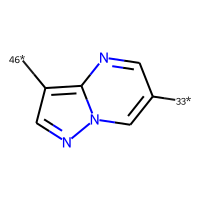
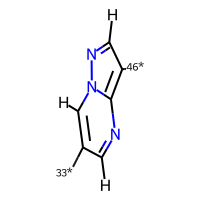
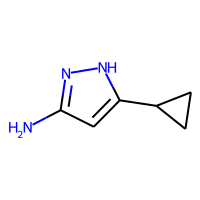
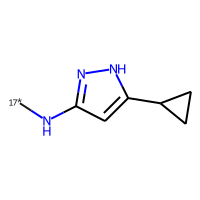
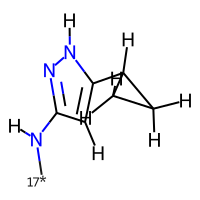
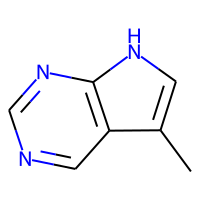
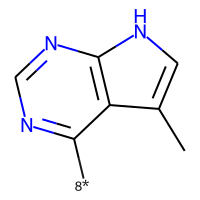
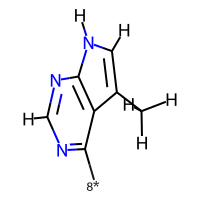
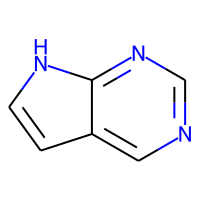
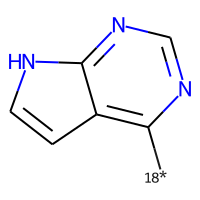
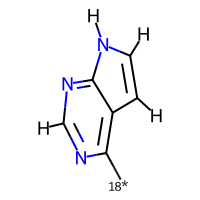
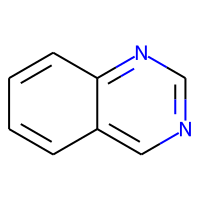
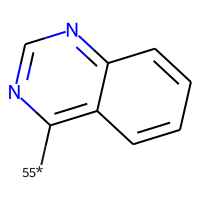
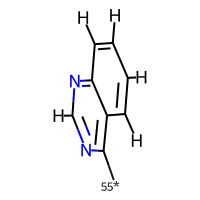

In [44]:
fragment_library_concat = pd.concat(fragment_library)
fragment_library_concat.head()

In [45]:
filters.retro.save_fragment_library_to_sdfs(
    PATH_DATA_CUSTOM,
    fragment_library_concat,
)